# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
!pip install -q scikit-plot
import scikitplot as skplt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
#for finding nonzero elements in sparse matrix
from scipy.sparse import find
#for f1_Score
from sklearn.metrics import f1_score
#for roc curve
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy.sparse import coo_matrix, hstack
from scipy import interp
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
#for SGD
from sklearn.linear_model import LogisticRegression
#for SVC
from sklearn.svm import SVC
#for others
from tqdm import tqdm
import os
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir drive
!google-drive-ocamlfuse drive


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [2]:
# using SQLite Table to read data.
os.chdir("/content/drive/Colab Notebooks") #changing directory
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:14<00:00, 1870.04it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

#[3.2] Splitting the data

In [24]:
final['Text'] = preprocessed_reviews
#sampling 100k point for linear SVM. Also balancing the data
finalp = final[final.Score == 1].sample(50000,random_state =2)
finaln = final[final.Score == 0].sample(50000,random_state =2)
finalx = pd.concat([finalp,finaln],ignore_index=True)
finalx = finalx.sort_values('Time')
y = finalx.Score.values
X = finalx.Text.values
X_tr100, X_test100 , y_tr100, y_test100 = train_test_split(X,y,test_size=0.3)
print(finalx.Score.value_counts())
print(X_tr100.shape,X_test100.shape,y_tr100.shape,y_test100.shape)
#Sampling 20k points for Kernel SVM. Also balancing the data
finalp = final[final.Score == 1].sample(10000,random_state =2)
finaln = final[final.Score == 0].sample(10000,random_state =2)
finalx = pd.concat([finalp,finaln],ignore_index=True)
finalx = finalx.sort_values('Time')
y = finalx.Score.values
X = finalx.Text.values
X_tr20, X_test20 , y_tr20, y_test20 = train_test_split(X,y,test_size=0.3)
print(final.Score.value_counts())
print(X_tr20.shape,X_test20.shape,y_tr20.shape,y_test20.shape)



1    50000
0    50000
Name: Score, dtype: int64
(70000,) (30000,) (70000,) (30000,)
1    307061
0     57110
Name: Score, dtype: int64
(14000,) (6000,) (14000,) (6000,)


In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
#BoW for linear SVM
count_vect1 = CountVectorizer(ngram_range=(1,2),min_df=10) #in scikit-learn
bow_vec_tr100 = count_vect1.fit_transform(X_tr100)
print("some feature names ", count_vect1.get_feature_names()[:10])
print('='*50)

bow_vec_test100 = count_vect1.transform(X_test100)
print("the type of count vectorizer ",type(bow_vec_tr100))
print("the shape of out text BOW vectorizer ",bow_vec_tr100.get_shape())
print("the number of unique words ", bow_vec_tr100.get_shape()[1])

#BoW for Kernel SVM
count_vect2 = CountVectorizer(ngram_range=(1,2),min_df=10,max_features = 5000) #in scikit-learn
bow_vec_tr20 = count_vect2.fit_transform(X_tr20)
print("some feature names ", count_vect2.get_feature_names()[:10])
print('='*50)

bow_vec_test20 = count_vect2.transform(X_test20)
print("the type of count vectorizer ",type(bow_vec_tr20))
print("the shape of out text BOW vectorizer ",bow_vec_tr20.get_shape())
print("the number of unique words ", bow_vec_tr20.get_shape()[1])

some feature names  ['aa', 'aafco', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'ability', 'able', 'able buy', 'able chew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 41647)
the number of unique words  41647
some feature names  ['ability', 'able', 'able buy', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely loves']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (14000, 5000)
the number of unique words  5000


## [4.2] Bi-Grams and n-Grams.

Already using BoW with bigrams.

## [4.3] TF-IDF

In [27]:
#fidf for linear SVM
tf_idf_vect1 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf_tr100 = tf_idf_vect1.fit_transform(X_tr100)
print("some sample features(unique words in the corpus)",tf_idf_vect1.get_feature_names()[0:10])
print('='*50)

tfidf_test100 = tf_idf_vect1.transform(X_test100)
print("the type of count vectorizer ",type(tfidf_tr100))
print("the shape of out text TFIDF vectorizer ",tfidf_tr100.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_tr100.get_shape()[1])

#tfidf for kernel SVM
tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=5000)
tfidf_tr20 = tf_idf_vect2.fit_transform(X_tr20)
print("some sample features(unique words in the corpus)",tf_idf_vect2.get_feature_names()[0:10])
print('='*50)

tfidf_test20 = tf_idf_vect2.transform(X_test20)
print("the type of count vectorizer ",type(tfidf_tr20))
print("the shape of out text TFIDF vectorizer ",tfidf_tr20.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_tr20.get_shape()[1])



some sample features(unique words in the corpus) ['aa', 'aafco', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'ability', 'able', 'able buy', 'able chew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (70000, 41647)
the number of unique words including both unigrams and bigrams  41647
some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely loves']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (14000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in final['Text'] :
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8943659663200378), ('terrific', 0.8936077356338501), ('awesome', 0.8790158033370972), ('excellent', 0.8656774163246155), ('good', 0.8644362092018127), ('wonderful', 0.8200923204421997), ('perfect', 0.7928048968315125), ('nice', 0.7638595700263977), ('amazing', 0.7473040819168091), ('incredible', 0.7327893972396851)]
[('nastiest', 0.8612643480300903), ('greatest', 0.7599353790283203), ('best', 0.7435747385025024), ('disgusting', 0.734964907169342), ('terrible', 0.7125589847564697), ('saltiest', 0.7073890566825867), ('horrible', 0.7041592597961426), ('awful', 0.6800963878631592), ('tastiest', 0.6779293417930603), ('worse', 0.6736702919006348)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  33573
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'recite', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'whales', 'india', 'drooping', 'roses', 'love', 'new', 'words', 'introduces', 'silliness', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'grew', 'reading', 'sendak', 'books', 'watching', 'really', 'rosie', 'movie', 'incorporates', 'loves', 'however', 'miss', 'hard', 'cover', 'version', 'seem', 'kind', 'flimsy', 'takes']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v for linear SVM

In [31]:
# average Word2Vec for training data
i=0
list_of_sent_intr100=[]
for sent in X_tr100:
    list_of_sent_intr100.append(sent.split())

# compute average word2vec for each review.
sent_vectors_intr100 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_intr100): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_intr100.append(sent_vec)
print(len(sent_vectors_intr100))
print(len(sent_vectors_intr100[0]))

# average Word2Vec for test data
i=0
list_of_sent_intest100=[]
for sent in X_test100:
    list_of_sent_intest100.append(sent.split())

# compute average word2vec for each review.
sent_vectors_intest100 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_intest100): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_intest100.append(sent_vec)
print(len(sent_vectors_intest100))
print(len(sent_vectors_intest100[0]))

  0%|          | 0/30000 [00:00<?, ?it/s]

70000
50


100%|██████████| 30000/30000 [01:44<00:00, 286.27it/s]

30000
50


#### [4.4.1.1.2] AVG W2V for Kernel SVM

In [32]:
# average Word2Vec for training data
i=0
list_of_sent_intr20=[]
for sent in X_tr20:
    list_of_sent_intr20.append(sent.split())

# compute average word2vec for each review.
sent_vectors_intr20 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_intr20): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_intr20.append(sent_vec)
print(len(sent_vectors_intr20))
print(len(sent_vectors_intr20[0]))

# average Word2Vec for test data
i=0
list_of_sent_intest20=[]
for sent in X_test20:
    list_of_sent_intest20.append(sent.split())

# compute average word2vec for each review.
sent_vectors_intest20 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_intest20): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_intest20.append(sent_vec)
print(len(sent_vectors_intest20))
print(len(sent_vectors_intest20[0]))

  1%|          | 31/6000 [00:00<00:20, 293.88it/s]

14000
50


100%|██████████| 6000/6000 [00:21<00:00, 284.03it/s]


6000
50


#### [4.4.1.2] TFIDF weighted W2v for linear SVM



In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=10)
tf_idf_matrix = model.fit_transform(X_tr100)
model.transform(X_test100)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_intr100 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_intr100): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_intr100.append(sent_vec)
    row += 1
    
tfidf_sent_vectors_intest100 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_intest100): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_intest100.append(sent_vec)
    row += 1
    
    


100%|██████████| 30000/30000 [04:49<00:00, 103.47it/s]


#### [4.4.1.2] TFIDF weighted W2v for kernel SVM



In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=10,max_features=5000)
tf_idf_matrix = model.fit_transform(X_tr20)
model.transform(X_test20)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [36]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_intr20 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_intr20): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_intr20.append(sent_vec)
    row += 1
    
tfidf_sent_vectors_intest20 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_intest20): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_intest20.append(sent_vec)
    row += 1
    
    


100%|██████████| 6000/6000 [00:42<00:00, 140.44it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

### Functions 

#### [5.0.1] Linear SVM

In [0]:
def hypertuning(traindata):

  kf = KFold(n_splits=5,random_state=3, shuffle=True)
  cv = []
  train = []
  alphas = [0.0001,0.001,0.01,0.1,1,10,100,10000]
  alphaslog = np.log(alphas)
  alphaslog.reshape(1,8)
  param_grid = {'alpha': [0.0001,0.001,0.01,0.1,1,10,100,10000], 'penalty': ['l1']}
  hyper = (ParameterGrid(param_grid))
  #finding best hyperparameter
  for i in range(8):
    
    for train_index,test_index in kf.split(traindata):
      xxtrain, xxtest = traindata[train_index], traindata[test_index]
      yytrain, yytest = y_tr100[train_index], y_tr100[test_index]
      clf = SGDClassifier()
      clf.set_params = hyper[i]
      clf.fit(xxtrain,yytrain)
      model = CalibratedClassifierCV(clf,cv = 'prefit')
      model.fit(xxtrain,yytrain)
      trainscores = []
      cvscores = []
      trainvalues = model.predict_proba(xxtrain)
    
      trainscores.append(roc_auc_score(yytrain,trainvalues[:,1]))
      cvvalues =model.predict_proba(xxtest)
      cvscores.append(roc_auc_score(yytest,cvvalues[:,1]))

    train.append(np.mean(trainscores))
    cv.append(np.mean(cvscores))
    trainscores = []
    cvscores = []

  for i in range(8):
    param_grid = {'alpha': [0.0001,0.001,0.01,0.1,1,10,100,10000], 'penalty': ['l2']}
    hyper = (ParameterGrid(param_grid))
    
    for train_index,test_index in kf.split(traindata):
      xxtrain, xxtest = traindata[train_index], traindata[test_index]
      yytrain, yytest = y_tr100[train_index], y_tr100[test_index]
      clf = SGDClassifier()
      clf.set_params = hyper[i]
      clf.fit(xxtrain,yytrain)
      model = CalibratedClassifierCV(clf,cv = 'prefit')
      model.fit(xxtrain,yytrain)
      trainscores = []
      cvscores = []
      trainvalues = model.predict_proba(xxtrain)
  
      trainscores.append(roc_auc_score(yytrain,trainvalues[:,1]))
      cvvalues =model.predict_proba(xxtest)
      cvscores.append(roc_auc_score(yytest,cvvalues[:,1]))

    train.append(np.mean(trainscores))
    cv.append(np.mean(cvscores))
    trainscores = []
    cvscores = []
  plt.figure()
  plt.plot(alphaslog,train[:8],'b',label='Train AUC with l1 reg')
  plt.plot(alphaslog,cv[:8],'r',label='CV AUC with l1 reg')
  plt.plot(alphaslog,train[8:16],'g',label='Train AUC with l2 reg')
  plt.plot(alphaslog,cv[8:16],'darkorange',label='CV AUC with l2 reg')
  plt.xlabel('alpha Value in natural log')
  plt.ylabel('Area Under ROC Curve')
  plt.gca().legend()
  plt.show()
   # determining alpha and reg by considering max cv
  cvl1 = np.mean(cv[0:8])
  cvl2 = np.mean(cv[8:16])
  if cvl1>cvl2:
    alphatrain = alphas[train[0:8].index(max(train[0:8]))]
    alphacv = alphas[cv[0:8].index(max(cv[0:8]))]
    reg = 'l1'
    optimal_alpha = np.median([alphacv,alphatrain])
  else:
    alphatrain = alphas[train[8:16].index(max(train[8:16]))]
    alphacv = alphas[cv[8:16].index(max(cv[8:16]))]
    reg = 'l2'
    optimal_alpha = np.median([alphacv,alphatrain])
    
  print('Optimal alpha is {} and reg is {}'.format(optimal_alpha,reg))

  return optimal_alpha,reg


In [0]:
#Applying SGD with optimal optimal alpha
def sgd_optimal(optimal_alpha,reg,Xtrain,Xtest):
  #training the data using optimal alpha and regularisation.
  model = SGDClassifier(alpha=optimal_alpha,penalty =reg)
  model.fit(Xtrain,y_tr100)
  p_train = model.predict(Xtrain)
  p_test = model.predict(Xtest)
  clf = CalibratedClassifierCV(model,cv = 2)
  clf.fit(Xtrain,y_tr100)
  pred_train = clf.predict_proba(Xtrain)
  pred_test = clf.predict_proba(Xtest)
  #Getting FPR AND TPR values for ROC Curve for train and test data
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fpr,tpr,_ = roc_curve(y_tr100,pred_train[:,1])
  roc_auc_train = roc_auc_score(y_tr100,pred_train[:,1])
  
  fpr2 = dict()
  tpr2 = dict()
  roc_auc2 = dict()
  fpr2,tpr2,_ = roc_curve(y_test100,pred_test[:,1])
  roc_auc_test = roc_auc_score(y_test100,pred_test[:,1])
  
  plt.figure()
  plt.title(" ROC Curve")
  plt.plot(fpr,tpr,'b',label='ROC curve for train data(area = %0.2f)' % roc_auc_train)
  plt.plot(fpr2,tpr2,'r',label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()
  
  #for confusion matrix
  print("Confusion Matrix for Train data")
  skplt.metrics.plot_confusion_matrix(y_tr100,p_train)
  print(classification_report(y_tr100,p_train))
  print("="*50)
  print("Confusion matrix for Test data")
  skplt.metrics.plot_confusion_matrix(y_test100,p_test)
  print(classification_report(y_test100,p_test))
  #for sparcity check
  w = model.coef_
  
  return w  



#### [5.0.2] RBF SVM

In [0]:
#SVM with RBF Kernel
def svmtuning(Xtrain):
#Giving C parameters
  C_parameters = [{'C': [0.0001,0.001,0.01,0.1,1,10,100,10000]}]
  C_values = [0.0001,0.001,0.01,0.1,1,10,100,10000]
  
#Using GridSearchCV
  validation_score = []
  train_score = []
  model = GridSearchCV(SVC(gamma="auto",probability=True), C_parameters, scoring = 'roc_auc',n_jobs=4, cv=2,return_train_score ='true')
  model.fit(Xtrain, y_tr20)
#Train and test results are in model.cv_results_  
  results = model.cv_results_
  validation_score = results['mean_test_score']
  train_score = results['mean_train_score']
# Changing c values to log for plotting  
  C_values_log = np.log(C_values)
  C_values_log.reshape(1,8)
#Get best estimator according to Gridsearchcv
  print(model.best_estimator_)
# Calculating best  c from train and test data by converting the array to list  
  validation_score = validation_score.tolist()
  train_score = train_score.tolist()
  optimal_c_cv = C_values[validation_score.index(max(validation_score))]
  optimal_c_tr = C_values[train_score.index(max(train_score))]
  log_tr = np.log(optimal_c_tr)
  log_cv = np.log(optimal_c_cv)
  optimal_c = float(np.exp((log_tr+log_cv)/2))
#plotting the curve  
  plt.figure()
  plt.title("AUC vs C")
  plt.plot(C_values_log,train_score,'b',label='Train AUC')
  plt.plot(C_values_log,validation_score,'darkorange',label='Validation AUC')
  plt.xlabel('C Value in natural log')
  plt.ylabel('Area Under ROC Curve')
  plt.gca().legend()
  plt.show()
  print('\nThe optimal c for training data is %f and ROC is %f.' % (optimal_c_tr,max(train_score)))
  print('\nThe optimal c for validation data is %f and ROC is %f.' % (optimal_c_cv,max(validation_score)))
  print('\nThe calculated optimal c for model is %f.' % optimal_c)
 
  return optimal_c


In [0]:
#Applying LR with optimal c
def svm_optimal(optimal_c,Xtrain,Xtest):
  #for ROC Curve on train data
  clf = SVC(C=optimal_c, gamma="auto",probability=True)
  clf.fit(Xtrain, y_tr20)
  pred_train = clf.predict_proba(Xtrain)
  #for ROC Curve on test data
  pred_test = clf.predict_proba(Xtest)
  #Getting FPR AND TPR values for ROC Curve for train and test data
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fpr,tpr,_ = roc_curve(y_tr20,pred_train[:,1])
  roc_auc_train = roc_auc_score(y_tr20,pred_train[:,1])
  
  fpr2 = dict()
  tpr2 = dict()
  roc_auc2 = dict()
  fpr2,tpr2,_ = roc_curve(y_test20,pred_test[:,1])
  roc_auc_test = roc_auc_score(y_test20,pred_test[:,1])
  
  plt.figure()
  plt.title(" ROC Curve")
  plt.plot(fpr,tpr,'b',label='ROC curve for train data(area = %0.2f)' % roc_auc_train)
  plt.plot(fpr2,tpr2,'r',label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()
  #for confusion matrix
  pred_train = clf.predict(Xtrain)
  #for ROC Curve on test data
  pred_test = clf.predict(Xtest)
  print("Confusion Matrix for Train data")
  skplt.metrics.plot_confusion_matrix(y_tr20,pred_train)
  print(classification_report(y_tr20,pred_train))
  print("="*50)
  print("Confusion matrix for Test data")
  skplt.metrics.plot_confusion_matrix(y_test20,pred_test)
  print(classification_report(y_test20,pred_test))

  

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

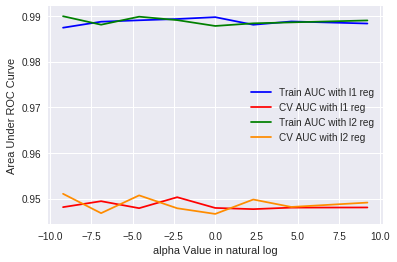

Optimal alpha is 0.0001 and reg is l2


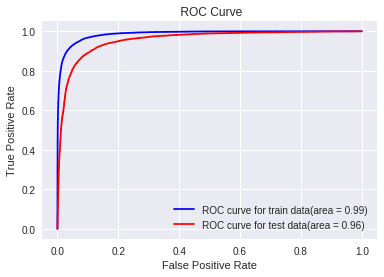

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     34969
           1       0.97      0.93      0.95     35031

   micro avg       0.95      0.95      0.95     70000
   macro avg       0.95      0.95      0.95     70000
weighted avg       0.95      0.95      0.95     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     15031
           1       0.91      0.87      0.89     14969

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.89      0.89      0.89     30000
weighted avg       0.89      0.89      0.89     30000



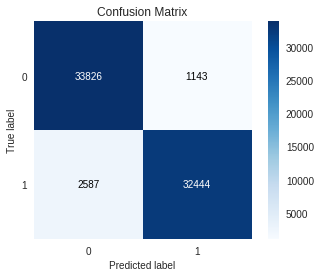

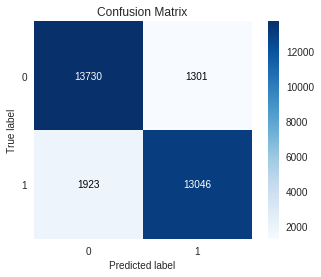

In [41]:
#getting alpha and regularisation
alpha,reg = hypertuning(bow_vec_tr100)
#applying linear svm
w = sgd_optimal(alpha,reg,bow_vec_tr100,bow_vec_test100)

In [42]:
# Getting feature names from BoW vectorizer
features_BoW = count_vect1.get_feature_names()

#Merging them into a dataframe.
top_features = pd.DataFrame(w,columns = features_BoW)
top_features = top_features.T
pos = top_features[top_features[0] > 0]
neg = top_features[top_features[0] < 0]
print(pos[0].sort_values(ascending=False)[0:10])


not disappointed    2.564110
skeptical           1.623936
go wrong            1.509976
four stars          1.481486
excellent           1.339035
not bitter          1.339035
addicting           1.310545
not overpowering    1.310545
delicious           1.310545
awesome             1.310545
Name: 0, dtype: float64


In [43]:
print(neg[0].sort_values(ascending=False)[0:10])

one opened           -5.055799e-18
hazelnut chocolate   -5.055799e-18
like straight        -1.011160e-17
quickly became       -1.011160e-17
repackaged           -1.011160e-17
know something       -1.011160e-17
makes question       -1.011160e-17
earth tea            -1.516740e-17
almost tasted        -1.516740e-17
made perfect         -1.516740e-17
Name: 0, dtype: float64


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

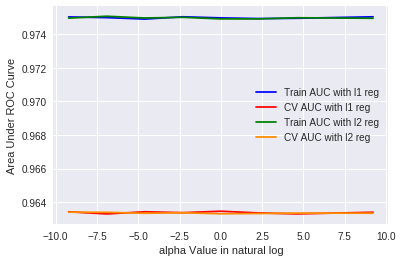

Optimal alpha is 0.55 and reg is l1


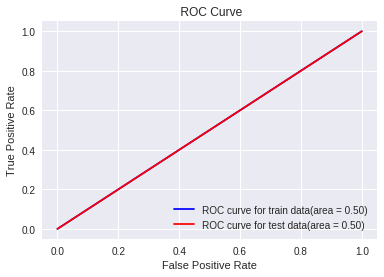

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     34969
           1       0.50      1.00      0.67     35031

   micro avg       0.50      0.50      0.50     70000
   macro avg       0.25      0.50      0.33     70000
weighted avg       0.25      0.50      0.33     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15031
           1       0.50      1.00      0.67     14969

   micro avg       0.50      0.50      0.50     30000
   macro avg       0.25      0.50      0.33     30000
weighted avg       0.25      0.50      0.33     30000



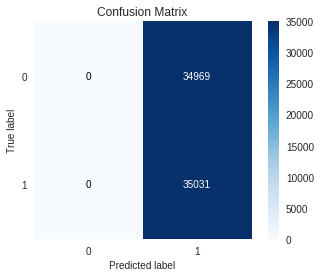

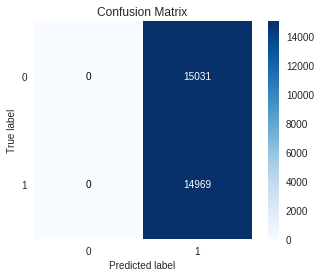

In [44]:
#getting alpha and regularisation
alpha,reg = hypertuning(tfidf_tr100)
#applying linear svm
w = sgd_optimal(alpha,reg,tfidf_tr100,tfidf_test100)

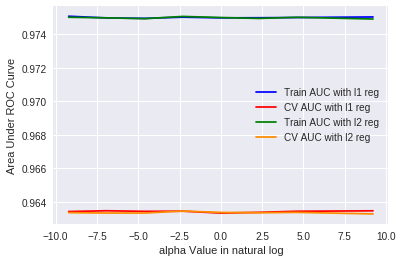

Optimal alpha is 0.00055 and reg is l1


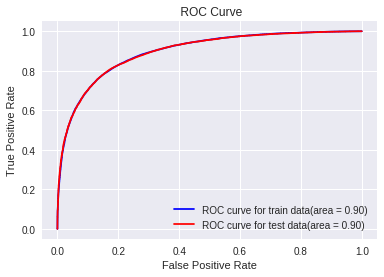

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     34969
           1       0.84      0.77      0.80     35031

   micro avg       0.81      0.81      0.81     70000
   macro avg       0.81      0.81      0.81     70000
weighted avg       0.81      0.81      0.81     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.79      0.86      0.82     15031
           1       0.84      0.77      0.80     14969

   micro avg       0.81      0.81      0.81     30000
   macro avg       0.81      0.81      0.81     30000
weighted avg       0.81      0.81      0.81     30000



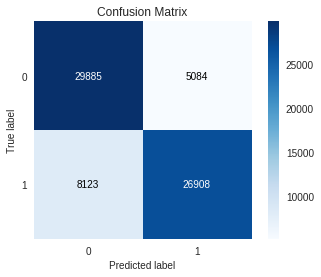

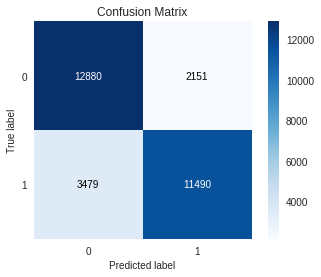

In [57]:
#trying again since we got a dumb model before
#getting alpha and regularisation
alpha,reg = hypertuning(tfidf_tr100)
#applying linear svm
w = sgd_optimal(alpha,reg,tfidf_tr100,tfidf_test100)

In [58]:
# Getting feature names from tfidf vectorizer
features_tfidf = tf_idf_vect1.get_feature_names()

#Merging them into a dataframe.
top_features = pd.DataFrame(w,columns = features_tfidf)
top_features = top_features.T
pos = top_features[top_features[0] > 0]
neg = top_features[top_features[0] < 0]
print(pos[0].sort_values(ascending=False)[0:10])


great        11.369413
best          8.665598
delicious     8.157048
good          7.148097
love          6.799800
perfect       6.142323
loves         5.900547
excellent     5.444510
favorite      5.420685
nice          4.652577
Name: 0, dtype: float64


In [59]:
print(neg[0].sort_values(ascending=False)[0:10])

never        -0.139290
boxes        -0.153466
instead      -0.193632
pieces       -0.220026
even         -0.236083
disgusting   -0.254741
tasteless    -0.262613
package      -0.297609
would not    -0.355368
products     -0.410200
Name: 0, dtype: float64


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [0]:
sent_vectors_intr100 = np.asmatrix(sent_vectors_intr100)
sent_vectors_intest100 = np.asmatrix(sent_vectors_intest100)

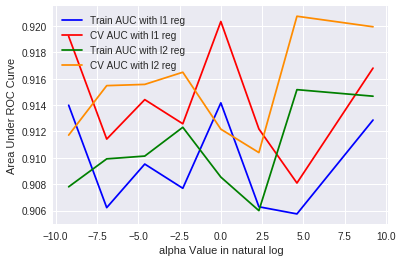

Optimal alpha is 100.0 and reg is l2


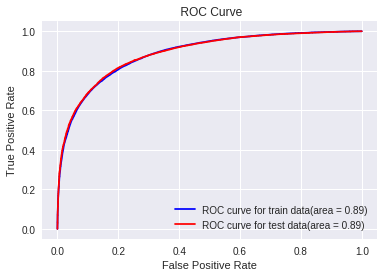

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     34969
           1       0.00      0.00      0.00     35031

   micro avg       0.50      0.50      0.50     70000
   macro avg       0.25      0.50      0.33     70000
weighted avg       0.25      0.50      0.33     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     15031
           1       0.00      0.00      0.00     14969

   micro avg       0.50      0.50      0.50     30000
   macro avg       0.25      0.50      0.33     30000
weighted avg       0.25      0.50      0.33     30000



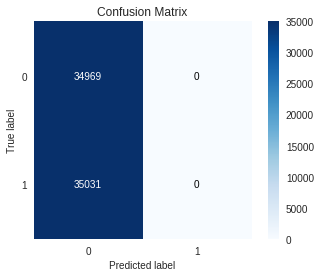

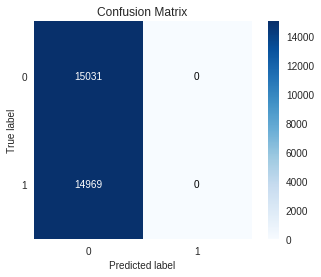

In [48]:
#getting alpha and regularisation
alpha,reg = hypertuning(sent_vectors_intr100)
#applying linear svm
w = sgd_optimal(alpha,reg,sent_vectors_intr100,sent_vectors_intest100)

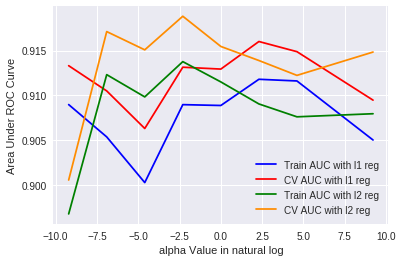

Optimal alpha is 0.1 and reg is l2


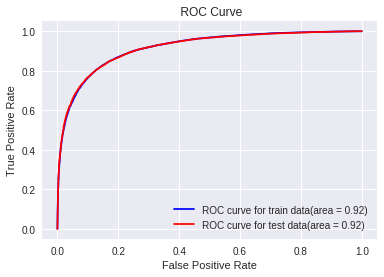

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     34969
           1       0.87      0.80      0.83     35031

   micro avg       0.84      0.84      0.84     70000
   macro avg       0.84      0.84      0.84     70000
weighted avg       0.84      0.84      0.84     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     15031
           1       0.86      0.80      0.83     14969

   micro avg       0.84      0.84      0.84     30000
   macro avg       0.84      0.84      0.84     30000
weighted avg       0.84      0.84      0.84     30000



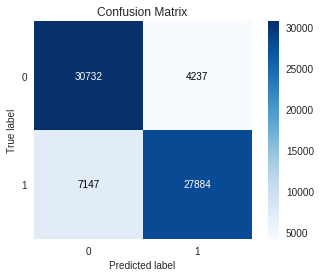

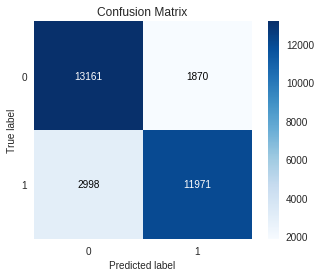

In [60]:
#trying again since we got a dumb model before
#getting alpha and regularisation
alpha,reg = hypertuning(sent_vectors_intr100)
#applying linear svm
w = sgd_optimal(alpha,reg,sent_vectors_intr100,sent_vectors_intest100)

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
tfidf_sent_vectors_intr100 = np.asmatrix(tfidf_sent_vectors_intr100)
tfidf_sent_vectors_intest100 = np.asmatrix(tfidf_sent_vectors_intest100)

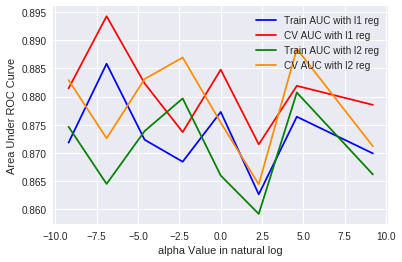

Optimal alpha is 0.001 and reg is l1


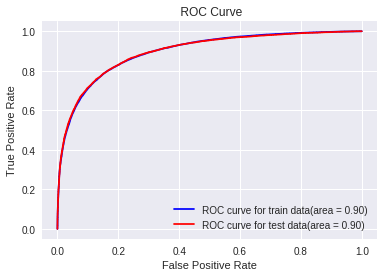

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.82      0.80      0.81     34969
           1       0.81      0.83      0.82     35031

   micro avg       0.81      0.81      0.81     70000
   macro avg       0.82      0.81      0.81     70000
weighted avg       0.82      0.81      0.81     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.83      0.80      0.81     15031
           1       0.81      0.83      0.82     14969

   micro avg       0.82      0.82      0.82     30000
   macro avg       0.82      0.82      0.82     30000
weighted avg       0.82      0.82      0.82     30000



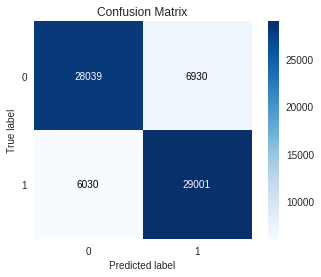

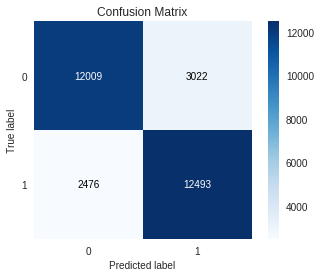

In [50]:
#getting alpha and regularisation
alpha,reg = hypertuning(tfidf_sent_vectors_intr100)
#applying linear svm
w = sgd_optimal(alpha,reg,tfidf_sent_vectors_intr100,tfidf_sent_vectors_intest100)

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


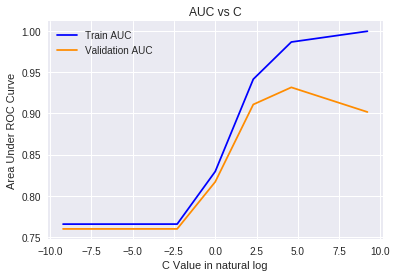


The optimal c for training data is 10000.000000 and ROC is 0.999996.

The optimal c for validation data is 100.000000 and ROC is 0.931740.

The calculated optimal c for model is 1000.000000.


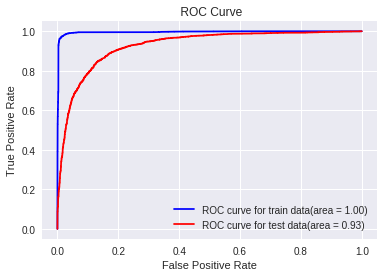

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7028
           1       0.98      0.98      0.98      6972

   micro avg       0.98      0.98      0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      2972
           1       0.86      0.86      0.86      3028

   micro avg       0.86      0.86      0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



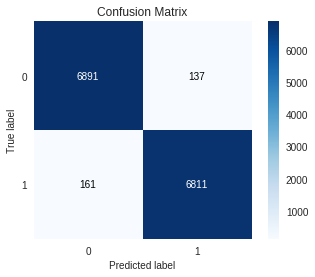

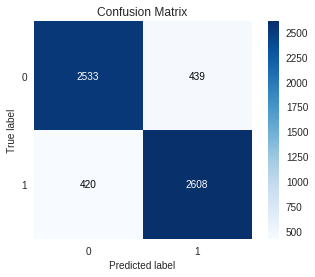

In [51]:
#Get optimal c
c = svmtuning(bow_vec_tr20)
#Applying RBF SVM on data
svm_optimal(c,bow_vec_tr20,bow_vec_test20)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


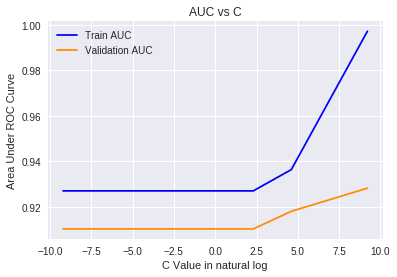


The optimal c for training data is 10000.000000 and ROC is 0.997122.

The optimal c for validation data is 10000.000000 and ROC is 0.928160.

The calculated optimal c for model is 10000.000000.


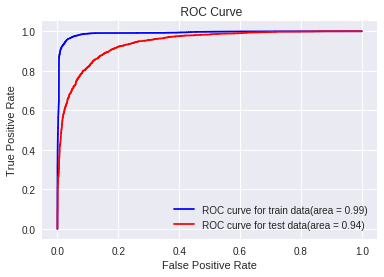

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7028
           1       0.96      0.96      0.96      6972

   micro avg       0.96      0.96      0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2972
           1       0.87      0.87      0.87      3028

   micro avg       0.87      0.87      0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



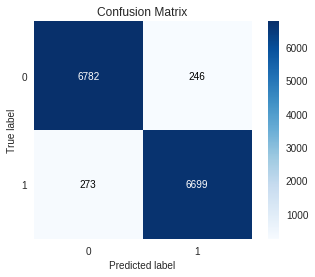

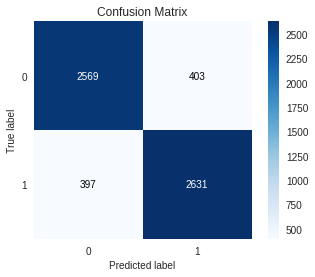

In [53]:
#Get optimal c
c = svmtuning(tfidf_tr20)
#Applying RBF SVM on data
svm_optimal(c,tfidf_tr20,tfidf_test20)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


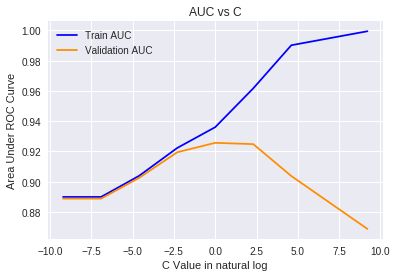


The optimal c for training data is 10000.000000 and ROC is 0.999496.

The optimal c for validation data is 1.000000 and ROC is 0.925695.

The calculated optimal c for model is 100.000000.


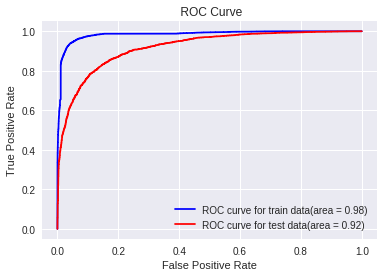

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7028
           1       0.96      0.94      0.95      6972

   micro avg       0.95      0.95      0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      2972
           1       0.85      0.83      0.84      3028

   micro avg       0.84      0.84      0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84      0.84      6000



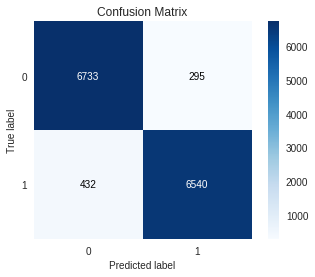

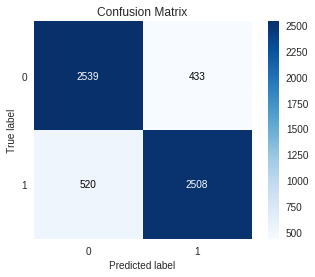

In [54]:
#Get optimal c
c = svmtuning(sent_vectors_intr20)
#Applying RBF SVM on data
svm_optimal(c,sent_vectors_intr20,sent_vectors_intest20)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


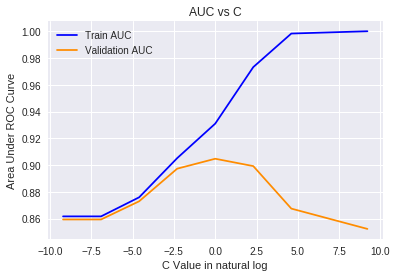


The optimal c for training data is 10000.000000 and ROC is 0.999921.

The optimal c for validation data is 1.000000 and ROC is 0.904731.

The calculated optimal c for model is 100.000000.


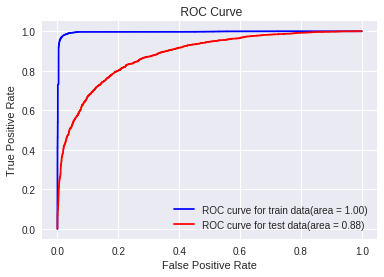

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      7028
           1       0.98      0.97      0.98      6972

   micro avg       0.98      0.98      0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2972
           1       0.81      0.79      0.80      3028

   micro avg       0.80      0.80      0.80      6000
   macro avg       0.80      0.80      0.80      6000
weighted avg       0.80      0.80      0.80      6000



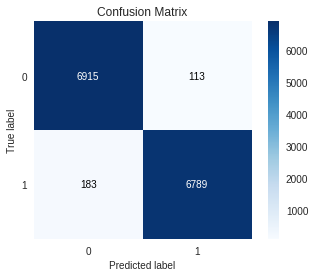

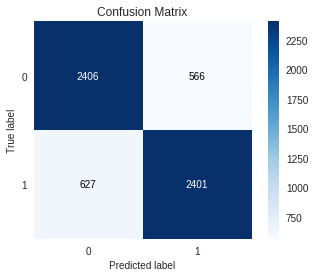

In [55]:
#Get optimal c
c = svmtuning(tfidf_sent_vectors_intr20)
#Applying RBF SVM on data
svm_optimal(c,tfidf_sent_vectors_intr20,tfidf_sent_vectors_intest20)

# [6] Conclusions

In [61]:
!pip install -q PTable
from prettytable import PrettyTable
z = PrettyTable()
z.field_names = ["Vectorizer", "Model", "Regularisation","Hyperparameter[α in linear and c in RBF SVM]", "AUC"]
#Final summary
z.add_row(["BoW", 'Linear SVM','l2',0.0001, '0.96'])
z.add_row(["BoW", 'Kernel SVM', '-',1000, '0.93'])
z.add_row(["TF_IDF",'Linear SVM','l1',0.00055, '0.90'])
z.add_row(["TF_IDF", 'Kernel SVM','-', 10000, '0.94'])
z.add_row(["Avg W2V", 'Linear SVM','l2', 0.1, '0.92'])
z.add_row(["Avg W2V", 'Kernel SVM', '-',100, '0.92'])
z.add_row(["TF_IDF weighted W2V",'Linear SVM','l1', 0.001, '0.90'])
z.add_row(["TF_IDF weighted W2V", 'Kernel SVM','-', 100, '0.88'])
print(z)

+---------------------+------------+----------------+----------------------------------------------+------+
|      Vectorizer     |   Model    | Regularisation | Hyperparameter[α in linear and c in RBF SVM] | AUC  |
+---------------------+------------+----------------+----------------------------------------------+------+
|         BoW         | Linear SVM |       l2       |                    0.0001                    | 0.96 |
|         BoW         | Kernel SVM |       -        |                     1000                     | 0.93 |
|        TF_IDF       | Linear SVM |       l1       |                   0.00055                    | 0.90 |
|        TF_IDF       | Kernel SVM |       -        |                    10000                     | 0.94 |
|       Avg W2V       | Linear SVM |       l2       |                     0.1                      | 0.92 |
|       Avg W2V       | Kernel SVM |       -        |                     100                      | 0.92 |
| TF_IDF weighted W2V | Line

CONCLUSIONS:

1.  Hyperparameters are to be chosen correctly. As can be observed in the above models in tfidf and avg w2v, the alpha chosen was different and gave dumb models. Sometimes we have to re run to get good results.
2. Here, standardising the data in some vectorizors also gave dumb models. It might be that the variance was lost due to standardisation.
3. Linear SVC was performed using SGDClasssifier using hinge loss(default).Since, it does not give probabiltiy estimates, calibratedclassifiercv was used, to get AUC.
3. In RBF SVM, the decision surface depends on hyperparameter c and gamma. Gamma was set to auto to get optimal gamma and GridSearch was done by setting SVC probability parameter as True.